In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
import shap

In [13]:
df = pd.read_csv('../data/raw/bank/bank-full.csv',sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [18]:
for col in df.columns:
    print(col,df[col].unique())

age [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]
job ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital ['married' 'single' 'divorced']
education ['tertiary' 'secondary' 'unknown' 'primary']
default ['no' 'yes']
balance [ 2143    29     2 ...  8205 14204 16353]
housing ['yes' 'no']
loan ['no' 'yes']
contact ['unknown' 'cellular' 'telephone']
day [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
duration [ 261  151   76 ... 1298 1246 1556]
campaign [ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 24 16 32 18 22 15 17 25 21
 43 51 63 41 26 28 55 50 38 23 20 29 31 37 30 46 27

In [ ]:
coded_df = df.copy()

# Make sure all categorical variables are of string type
categorical_cols = ["job", "marital", "education", "default", "housing", "loan",
                    "contact", "month", "poutcome"]
coded_df[categorical_cols] = coded_df[categorical_cols].astype(str)

# 1. Handling binary variables (default, housing, loan)
binary_cols = ["default", "housing", "loan", "contact", "poutcome"]
for col in binary_cols:
    if col == "contact":
        coded_df[col] = coded_df[col].map({"telephone": 1, "cellular": 2, "unknown":0})
    elif col == "poutcome":
        coded_df[col] = coded_df[col].map({"unknown": 0, "failure": -1, "success": 1, "other":2})
    else:
        coded_df[col] = coded_df[col].map({"no": -1, "yes": 1, "unknown": 0})  # Handling unknown values

# 2. deal with time variable(month, day_of_week)
month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

# Mapping Values
coded_df["month"] = coded_df["month"].map(month_mapping)

# 3. One-Hot Encoding of the remaining categorical variables
onehot_cols = ["job", "marital", "education"]
encoder = OneHotEncoder(sparse_output=False, drop=None, handle_unknown="ignore")
encoded_features = encoder.fit_transform(coded_df[onehot_cols])

# Creating One-Hot DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(onehot_cols))

# 4. Merge One-Hot Encoded Data
coded_df = coded_df.drop(columns=onehot_cols).reset_index(drop=True)
coded_df = pd.concat([coded_df, encoded_df], axis=1)

# 5. Target variable encoding
coded_df["y"] = coded_df["y"].map({"no": 0, "yes": 1})

# coded_df.to_csv("bank_processed.csv", index=False)

# 6. View the encoded data
coded_df.head()

,age,default,balance,housing,loan,contact,day,month,duration,campaign,...,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown
0,58,-1,2143,1,-1,0,5,5,261,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,44,-1,29,1,-1,0,5,5,151,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,33,-1,2,1,1,0,5,5,76,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,47,-1,1506,1,-1,0,5,5,92,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,33,-1,1,-1,-1,0,5,5,198,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


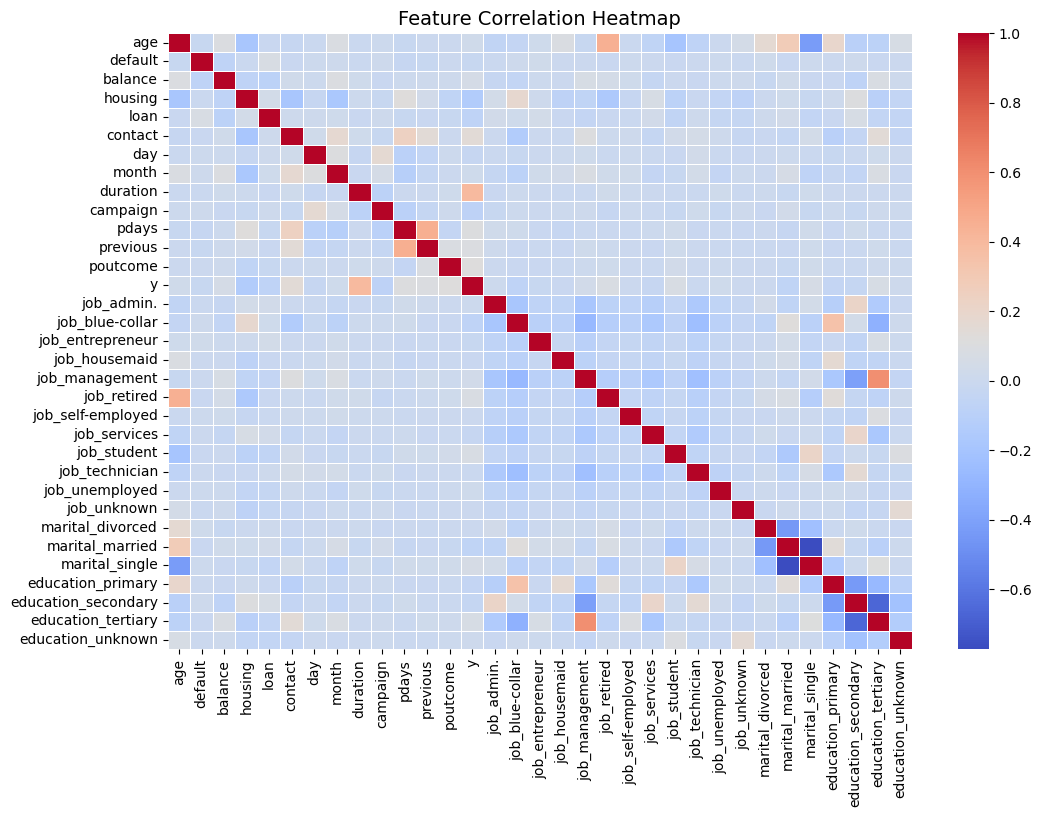

In [ ]:
# Calculate the correlation coefficient matrix
corr_matrix = coded_df.corr()

# Set the graphics size
plt.figure(figsize=(12, 8))

# Draw a heat map
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)

# Set the title
plt.title("Feature Correlation Heatmap", fontsize=14)

# Display the image
plt.show()

In [35]:
# Split features (X) and target variable (y)
X = coded_df.drop(columns=["y"])
# X = coded_df.drop(columns=["y","contact","day","month","duration","campaign","pdays","previous","poutcome"])
y = coded_df["y"]

# 80% training set, 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Defining the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",  # Suitable for binary classification tasks
    eval_metric="logloss",  # Evaluation indicators
)

# model training
xgb_clf.fit(X_train, y_train)

# predict
y_pred = xgb_clf.predict(X_test)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuary: {acc:.4f}")

XGBoost Accuary: 0.9076


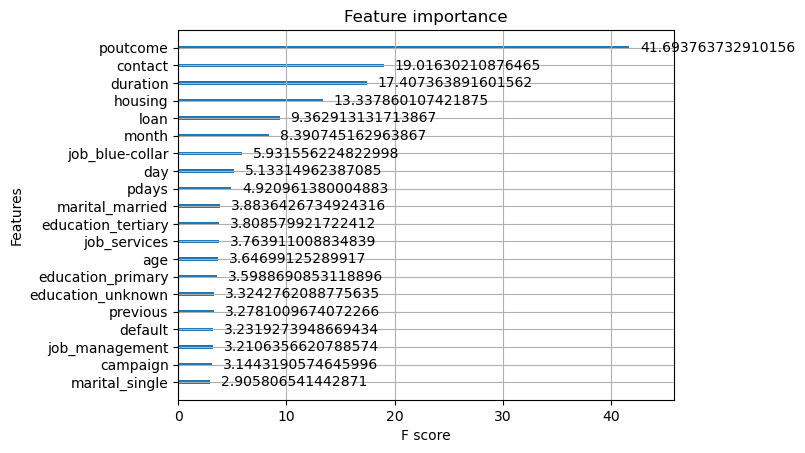

In [37]:
xgb.plot_importance(xgb_clf, importance_type="gain", max_num_features=20)  # top 20 features
plt.show()

X-axis: SHAP values, representing the impact of a feature on the prediction (positive means increasing the probability of subscription, negative means decreasing).

Y-axis: Feature names, sorted by importance from top to bottom.

**Color**:

    -Red (high values): The feature has a high numerical value.
    
    -Blue (low values): The feature has a low numerical value.
    
**Scatter distribution**:

    -If high values (red) are on the right, increasing this feature increases subscription likelihood.
    
    -If high values (red) are on the left, increasing this feature decreases subscription likelihood.
    
    -If there’s no clear trend, the feature's influence is more complex.

 96%|=================== | 8699/9043 [00:14<00:00]       

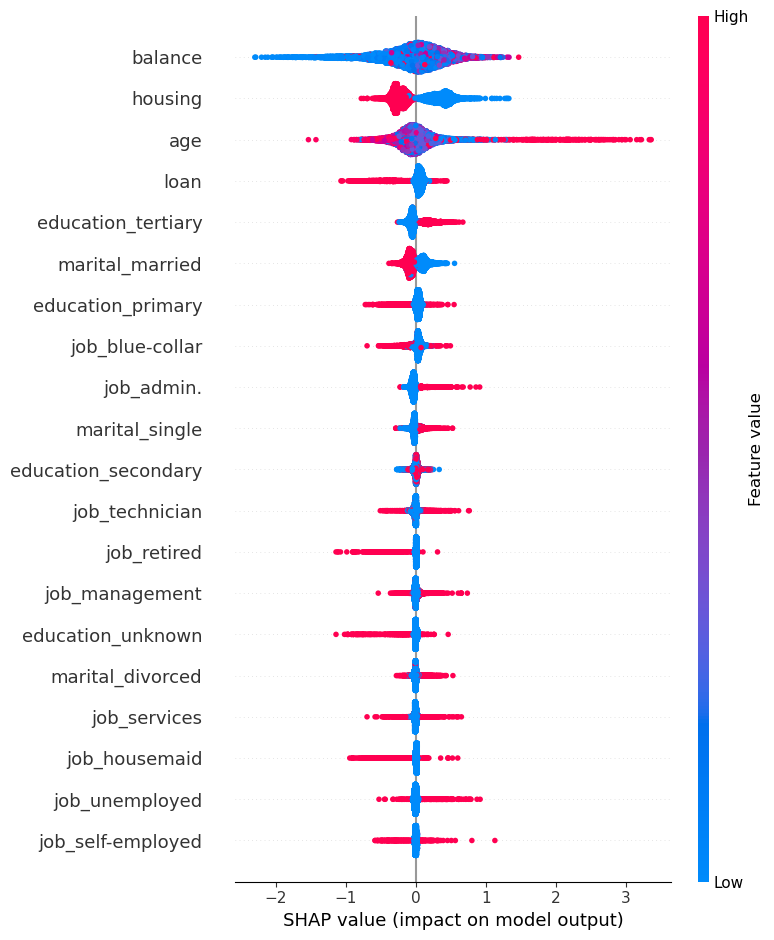

In [28]:
# Calculating SHAP Values
explainer = shap.Explainer(xgb_clf, X_train)
shap_values = explainer(X_test)

# Draw the overall impact
shap.summary_plot(shap_values, X_test)

**Vertical axis**: variable name (sorted by interaction SHAP importance).

**Horizontal axis**: interaction SHAP value (positive value indicates positive contribution to y=1, negative value indicates greater contribution to y=0).

**Color**: feature value size (red = larger value, blue = smaller value).

**Distribution of points**: The denser the points, the more stable the interaction effect of the feature.

d:\software\Anaconda3\lib\site-packages\shap\plots\_beeswarm.py:600: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))
d:\software\Anaconda3\lib\site-packages\shap\plots\_beeswarm.py:619: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))
d:\software\Anaconda3\lib\site-packages\shap\plots\_beeswarm.py:619: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))
d:\software\Anaconda3\lib\site-packages\shap\plots\_beeswarm.py:619: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))
d:\software\Anaconda3\lib\site-packages\shap\plots\_beeswarm.py:619: UserWarning: Attempting to set identical low and high xlims makes transformation singular; 

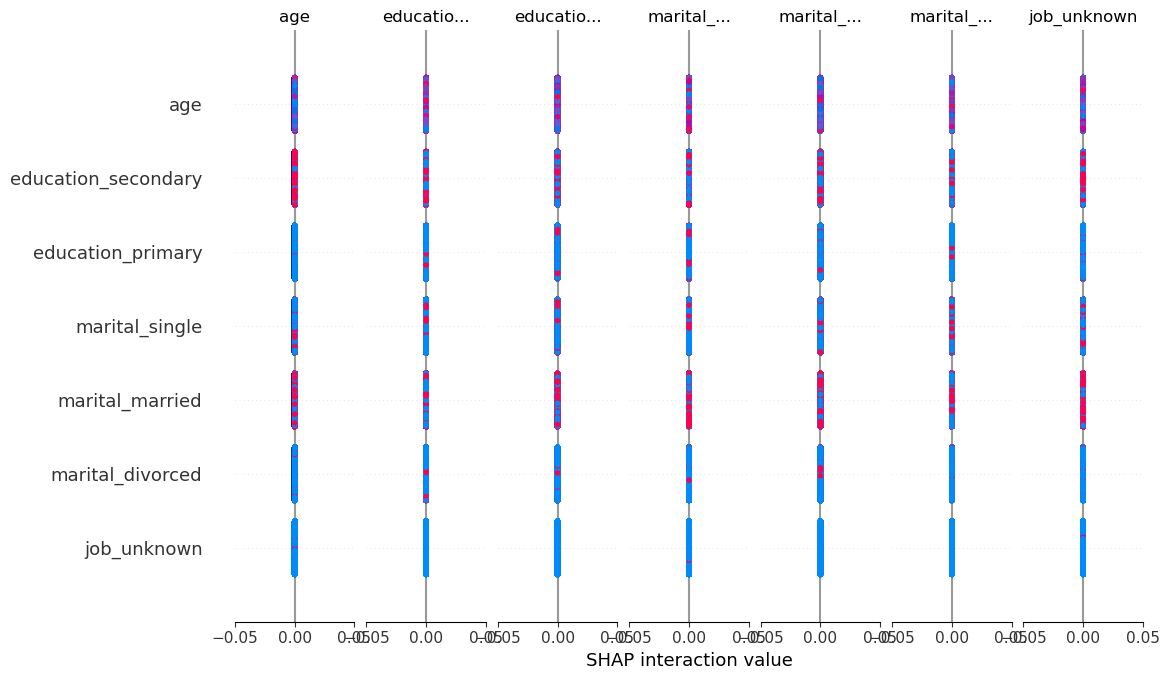

In [29]:
# Calculating SHAP interaction values
shap_interaction_values = explainer.shap_interaction_values(X)

# Visualizing Cross-Factor SHAP Values
shap.summary_plot(shap_interaction_values, X)

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# 2. Build a logistic regression pipeline
model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42,class_weight="balanced"))
])

# 3. Training the Model
model.fit(X_train, y_train)

# 4. Prediction
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 5. Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

Accuracy: 0.6207010947694349
ROC AUC: 0.6751096058477353
              precision    recall  f1-score   support

           0       0.93      0.62      0.74      7952
           1       0.19      0.65      0.29      1091

    accuracy                           0.62      9043
   macro avg       0.56      0.63      0.52      9043
weighted avg       0.84      0.62      0.69      9043



In [33]:
# View features that influence ranking
feature_importance = model.named_steps["logreg"].coef_[0]
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importance})
importance_df.sort_values(by="Importance", ascending=False, inplace=True)
print(importance_df)

                Feature  Importance
10          job_retired    0.141091
22   education_tertiary    0.097502
2               balance    0.096698
19       marital_single    0.091929
13          job_student    0.091635
5            job_admin.    0.047079
15       job_unemployed    0.043626
0                   age    0.031325
17     marital_divorced   -0.004211
9        job_management   -0.006505
23    education_unknown   -0.009118
11    job_self-employed   -0.010419
21  education_secondary   -0.013853
16          job_unknown   -0.022827
12         job_services   -0.023166
14       job_technician   -0.029943
8         job_housemaid   -0.037260
7      job_entrepreneur   -0.040368
1               default   -0.064766
6       job_blue-collar   -0.069060
18      marital_married   -0.081852
20    education_primary   -0.099247
4                  loan   -0.181618
3               housing   -0.351962


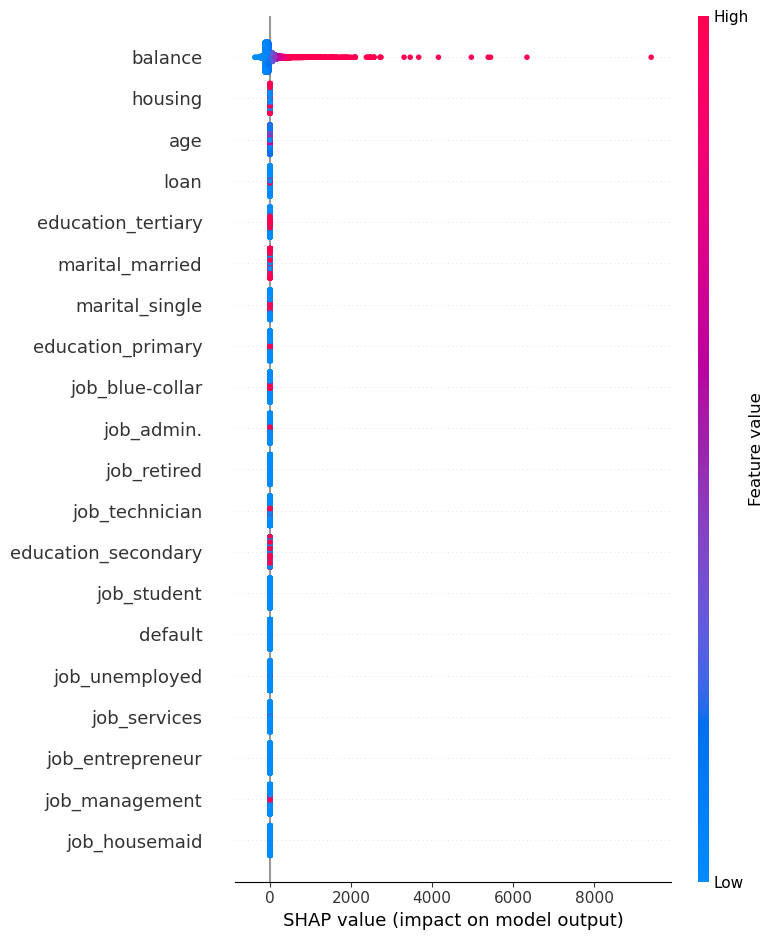

In [34]:
explainer = shap.LinearExplainer(model.named_steps["logreg"], X_train)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)
plt.show()